## TUTORIAL W40

In W38 we started this tutorial about how to analyse visual responses.
Steps included:  
- preprocessing
     - artefact rejection
     - filtering
- epoching
     - rejecting based on peak-to-peak amplitude
- evoked responses
      - difference waves
- estimating noise covariance
      - whitening the data
- do an inverse model (MNE)
- extract labels from the cerebral cortex
    - plot source times courses from different labels
    - do difference plots
- do a multivariate analysis in source space
    - (doing it in sensor space is left as an exercise to the reader)
 
You can either finish the tutorial on the sample data set or start applying it to the workshop data.
The old code is left in; but (mostly) commented out

Recommended Gb=12, 1 CPU



In [1]:
## IMPORTS AND DEFAULT PLOTTING PARAMETERS

import mne ## MNE-Python for analysing data
## below magic provides interactive plots in notebook
%matplotlib widget
from os import chdir
from os.path import join
import matplotlib.pyplot as plt ## for basic plotting
import matplotlib as mpl ## for setting default parameters
import pandas as pd

## SAMPLE DATA SET (https://mne.tools/stable/documentation/datasets.html#sample)
*These data were acquired with the Neuromag Vectorview system at MGH/HMS/MIT Athinoula A. Martinos Center Biomedical Imaging. EEG data from a 60-channel electrode cap was acquired simultaneously with the MEG. The original MRI data set was acquired with a Siemens 1.5 T Sonata scanner using an MPRAGE sequence.*

*In this experiment, checkerboard patterns were presented to the subject into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the face.*

Change the path to your relevant path below

In [2]:
#%% LOAD SAMPLE DATA SET

#sample_path = '/work/MEG_data/MNE-sample-data' ## UCloud
#sample_meg_path = join(sample_path, 'MEG', 'sample')
#chdir(sample_meg_path)
#subjects_dir = '../../subjects/'

#%% LOAD YOUR FAVOURITE SUBJECT

MEG_path = '/work/MEG_data/workshop_data/0169/20250923_000000' ## you can pick your study group member
subjects_dir = '/work/freesurfer'
behaviour_path = '/work/MEG_data/workshop_data/behavioural_logs'

## INSPECT RAW DATA

### NEW INFO - workshop data

Note how plotting it will seem meaningless; it is all saturated. Do a PSD to find out why

### OLD INFO - sample data

First try to identify the two bad channels, one electrode and one planar gradiometer.  
(They have been greyed out; also notice that you can mark channels as bad by clicking them and "unbadding" them by clicking it again)
Do notice that the two marked channels look considerably different than the others  
The bad channels can also be found by `raw.info['bads']`
The x-axis has time and the y-axes, magnetic field (T), magnetic gradient (T/m) or voltage (V)
This is your $\boldsymbol b(t)$

Opening raw data file /work/MEG_data/workshop_data/0169/20250923_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 2024000 ... 3601999 =   2024.000 ...  3601.999 secs
Ready.
Reading 0 ... 1577999  =      0.000 ...  1577.999 secs...
Using matplotlib as 2D backend.


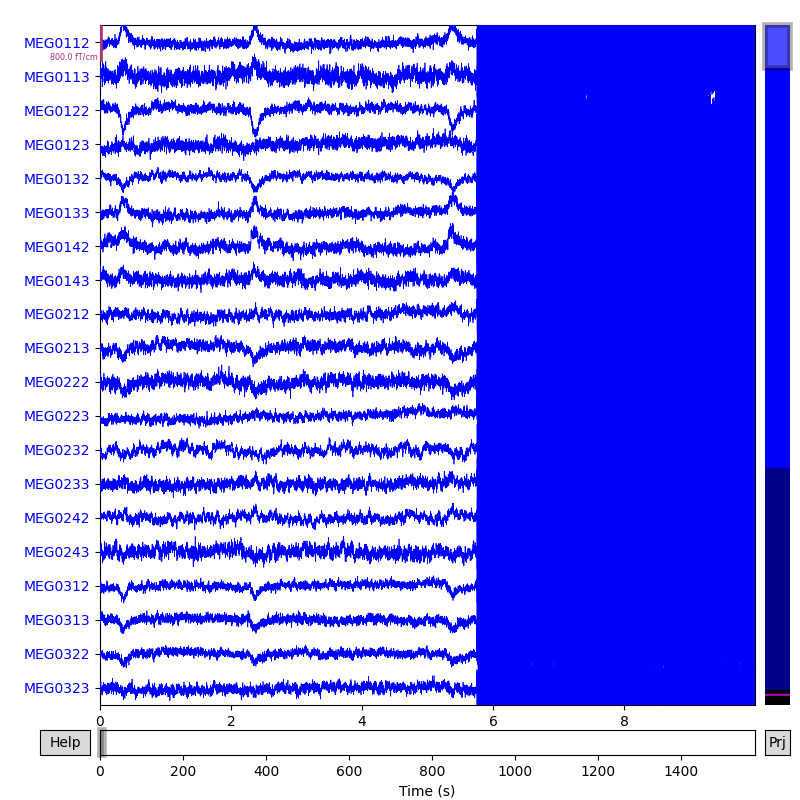

In [3]:
#%% READ RAW

#raw = mne.io.read_raw_fif('sample_audvis_raw.fif', preload=True)
raw = mne.io.read_raw_fif(join(MEG_path, 'workshop_2025_raw.fif'), preload=True) 
fig = raw.plot() ## you will note this is completely saturated (all blue) do the PSD and find out why

## IDENTIFYING HPI-FREQUENCIES FROM THE POWER SPECTRAL DENSITY (PSD)

### NEW INFO

The X-axis contains the frequency (Hz) and the y-axis the power of each for each frequency in dB. Here you can also click and toggle bad channels.
What frequencies do the HPI run at, do you think, and would that necessitate a filter?

### OLD INFO

Now we will see the two bad channels in the power spectral density.
Describe to yourself how they differ from the rest. Often bad channels are easier to identify here than in the raw traces
The X-axis contains the frequency (Hz) and the y-axis the power of each for each frequency in dB. Here you can also click and toggle bad channels.

In [4]:
raw.compute_psd().plot();

Effective window size : 2.048 (s)


KeyboardInterrupt: 

## FILTERING

### NEW CODE

You would want to do something about those HPI-frequencies saturating the signal

### OLD CODE

With filtering, we can reduce the contributions of frequencies that contain signal that is not of interest to our analysis.
For each of the copies, compute a psd and ascertain for yourself what they do and not do

In [ ]:
#%% CHOOSE A FILTER TO APPLY TO YOUR RAW DATA - 

copy_bandpass = raw.copy()
copy_bandpass.filter(h_freq=40,   l_freq=1); ## bandpass fillter of 1-40 Hz
filtered = copy_bandpass

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


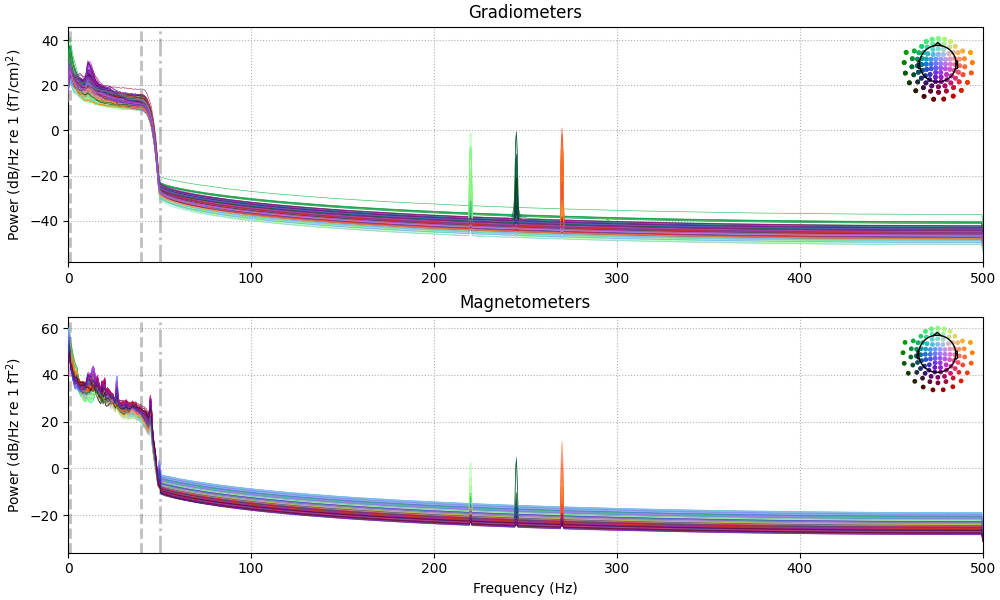

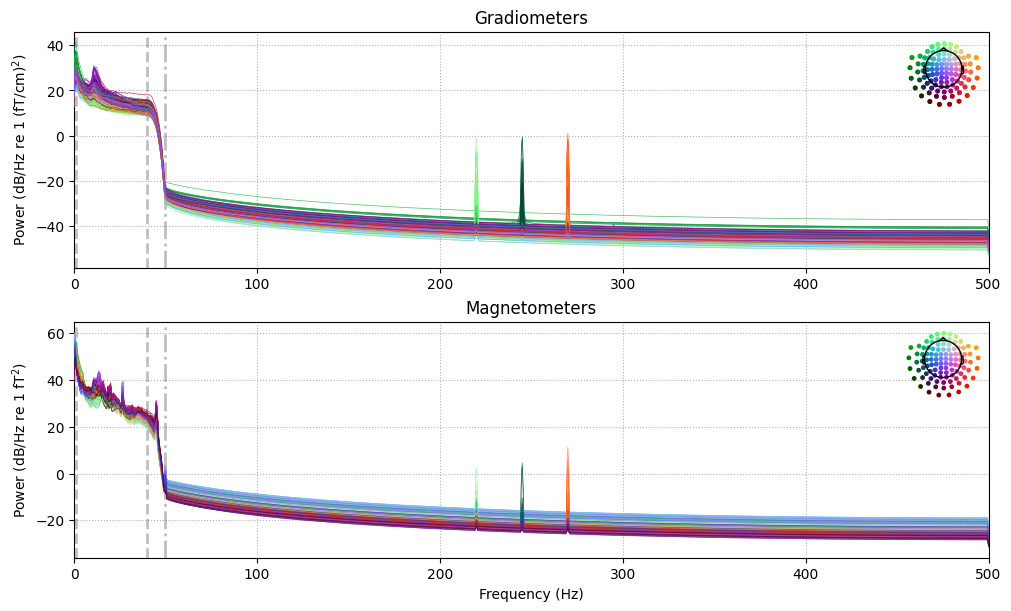

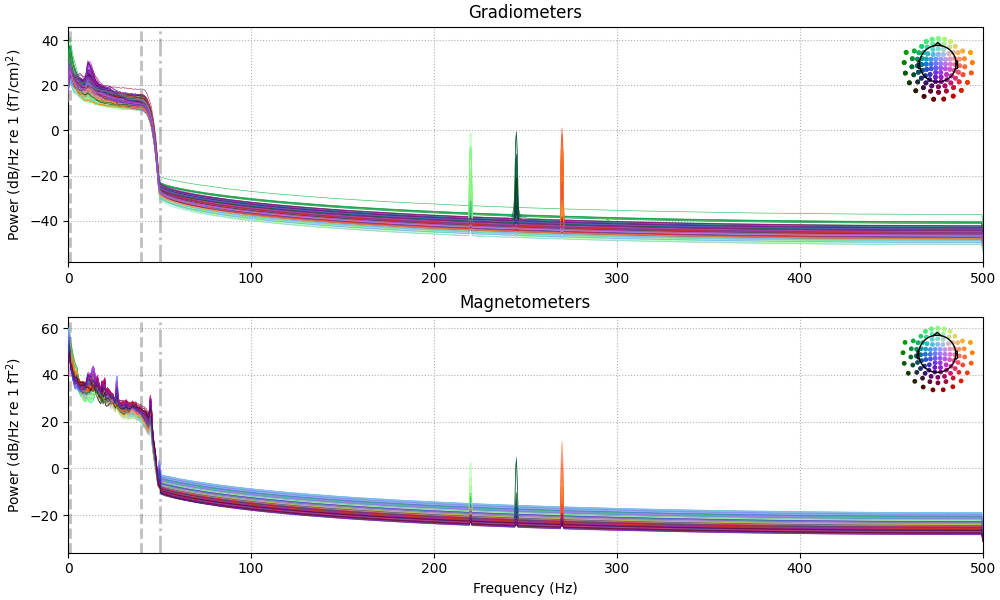

In [ ]:
## what does it look after choosing an appropriate filter?
filtered.compute_psd().plot()

## FIND THE EVENTS

Pick the ones that you want to analyse further - you might get an error about *min_duration*; if you do, set that to 0.002 (s)

In [ ]:
#%% FIND EVENTS

events = mne.find_events(raw)

# Check the set_experiment parameters methods in the class Experiment
## https://github.com/ualsbombe/2025_advanced_cognitive_neuroscience/blob/main/experiment/subjective_experience_v2.py

Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]


## CHANGE EVENTS

If you want to change some of the events, this is also possible. `events` is an `(n_events, 3)` array, with the first column, having the time stamps of the event and the third column having the trigger codes.
Please also not that the trial number inadventenly has not been recorded; and all columns from all trial number should be moved one column to the right. *subjective_response* is thus really under *objective_response_time_ms*

In [ ]:
behaviour = pd.read_csv(join(behaviour_path, '0169_2025_09_23_110138_experiment_data.csv'), index_col=False,)
print(behaviour)


     subject  trial_number  staircase_number  fixation_duration_ms  \
0        169             0                 0            716.666667   
1        169             1                 0            700.000000   
2        169             2                 0            566.666667   
3        169             3                 0            733.333333   
4        169             4                 0            575.000000   
..       ...           ...               ...                   ...   
395      169            35                 9            683.333333   
396      169            36                 9            600.000000   
397      169            37                 9            616.666667   
398      169            38                 9            525.000000   
399      169            39                 9            533.333333   

     target_duration_ms target_type  target_contrast  mask_duration_ms  \
0             33.333333  stimulus_1         0.400000         33.333333   
1          

In [ ]:
behaviour["subjective_response"].value_counts()

subjective_response
2    139
3    120
4     79
1     62
Name: count, dtype: int64

In [ ]:
print(events)

[[2089664       0       3]
 [2089698       0       4]
 [2091882       0       8]
 ...
 [3591476       0       4]
 [3592360       0       8]
 [3592855       0      10]]


In [ ]:
target_indices = events[:, 2] < 4
events[target_indices, 2] = behaviour["subjective_response"] + 20

In [ ]:
event_id = dict(NE=21, WG=22, ACE=23, CE=24)
event_id

{'NE': 21, 'WG': 22, 'ACE': 23, 'CE': 24}

## CREATING EPOCHS


### NEW CODE

Keep it simple and create epochs without `reject`
Choose a meaningful `tmin` and `tmax` and a meaningful `baseline` (the response time of subjects could inform `tmin` and `tmax`)
Also include relevant events using `event_id` as  a `dict`


### OLD CODE
Create epochs using `mne.Epochs`. Specifically, create two epochs_objects: `epochs` and `epochs_eog_cleaned`.
- In both:
    - include 200 ms before each visual event and 550 ms after each event.
    - make sure to include both checkerboard stimuli epochs
    - do the demeaning by creating a baseline interval from 200 ms to 0 ms.
    - apply the `set_eeg_reference(projection=True)` to both
- In `epochs_eog_cleaned`:
    - include a `reject` dict that removes epochs where the peak-to-peak amplitude of eye-related activity (EOG) exceeds 250 µV
Check out https://mne.tools/stable/generated/mne.Epochs.html


In [ ]:
    # NEW CODE\n,

    epochs = mne.Epochs(filtered,\n",
                        events,\n",
                        event_id=event_id,\n",
                        tmin=-0.200,\n",
                        tmax=0.550,\n",
                        baseline=(-0.200,0))\n",
    
    
    "## OLD CODE\n",
    "\n",
    "#epochs = mne.Epochs(?)\n",
    "#epochs_eog_cleaned = mne.Epochs(?)\n",
    "\n",
    "\n",
    "epochs_eog_cleaned = mne.Epochs(filtered,\n",
    "                    events,\n",
    "                    event_id=event_id,\n",
    "                    tmin=-0.200,\n",
    "                    tmax=0.550,\n",
    "                    baseline=(-0.200,0),\n",
    "                    reject = dict(eog=250e-6))"
   ]
  },

In [ ]:
## NEW CODE


## creating epochs
epochs = mne.Epochs(raw,
                    events,
                    event_id = event_id,
                    tmin = -0.200,
                    tmax = 0.550,
                    baseline = (-0.200, 0),
                    preload = True)

epochs_eog_cleaned = mne.Epochs(raw,
                    events,
                    event_id = event_id,
                    tmin = -0.200,
                    tmax = 0.550,
                    baseline = (-0.200, 0),
                    reject = dict(eog=250e-6), # rejecting epochs with eog signal above 250 microvolt
                    preload = True) # telling it to apply the rejection

Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 400 events and 751 original time points ...
0 bad epochs dropped
Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 400 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoc

## CREATE AVERAGES AND DIFFERENCE WAVES

It would be worth checking what the difference waves look like for the evoked responses associated with different levels of subjective experience

In [ ]:
## CREATING AVERAGES AND DIFFERENCE WAVES

### NEW CODE

evokeds = list()
for event in epochs.event_id:
    evokeds.append(epochs[event].average())

## this might help you along
evoked_diffs = list()
diffs_comment = ['WG-NE', 'ACE-WG','ACE-WG', 'CE-NE']
diffs = [(1, 0), (2, 1), (3, 2), (3, 0)]
i=0
for diff in diffs:
    evoked_diff = evokeds[diff[0]].copy() # create a copy
    evoked_diff.data -= evokeds[diff[1]].data # modify the data in place
    evoked_diff.comment = diffs_comment[i]
    i += 1
    evoked_diffs.append(evoked_diff)



### OLD CODE

#evokeds = list()
#evokeds_eog_cleaned = list()
#for event in epochs.event_id:
#    evokeds.append(epochs[event].average())
#    evokeds_eog_cleaned.append(epochs_eog_cleaned[event].average())

#evoked_diff = evokeds[0].copy() # create a copy
#evoked_diff.data -= evokeds[1].data # modify the data in place
#evoked_diff.comment = 'LV - RV'



In [ ]:
evokeds

[<Evoked | 'NE' (average, N=62), -0.2 – 0.55 s, baseline -0.2 – 0 s, 306 ch, ~7.0 MiB>,
 <Evoked | 'WG' (average, N=139), -0.2 – 0.55 s, baseline -0.2 – 0 s, 306 ch, ~7.0 MiB>,
 <Evoked | 'ACE' (average, N=120), -0.2 – 0.55 s, baseline -0.2 – 0 s, 306 ch, ~7.0 MiB>,
 <Evoked | 'CE' (average, N=79), -0.2 – 0.55 s, baseline -0.2 – 0 s, 306 ch, ~7.0 MiB>]

In [ ]:
evoked_diff

<Evoked | 'CE-NE' (average, N=79), -0.2 – 0.55 s, baseline -0.2 – 0 s, 306 ch, ~7.0 MiB>

In [ ]:
#epochs = mne.Epochs(filtered,
#                    events,
#                    event_id=event_id,
#                    tmin=-0.200,
#                    tmax=0.550,
#                    baseline=(-0.200,0),
#                    picks= ['MEG2043']
#                    )

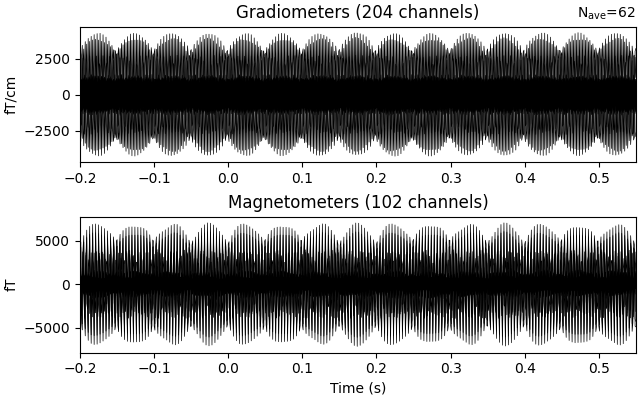

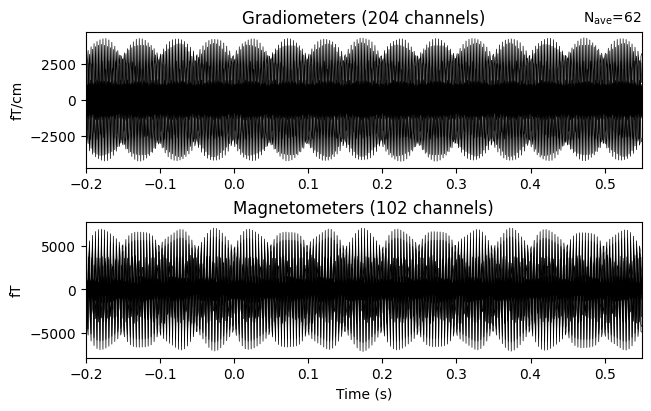

In [ ]:
mne.viz.plot_evoked(evokeds[0])

Need more than one channel to make topography for grad. Disabling interactivity.


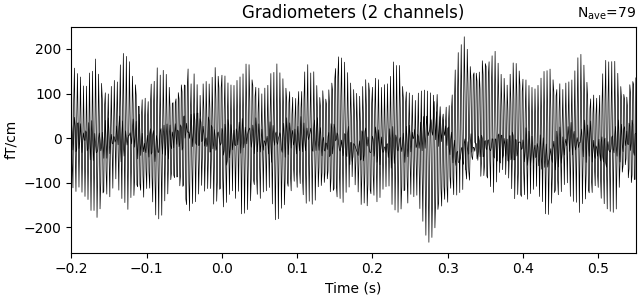

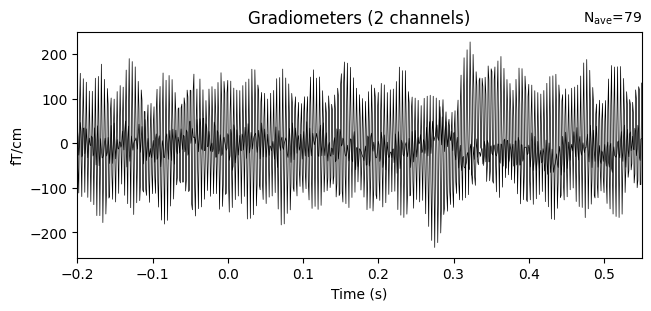

In [ ]:
mne.viz.plot_evoked(evoked_diffs[3], picks=["MEG2042", "MEG2043"])

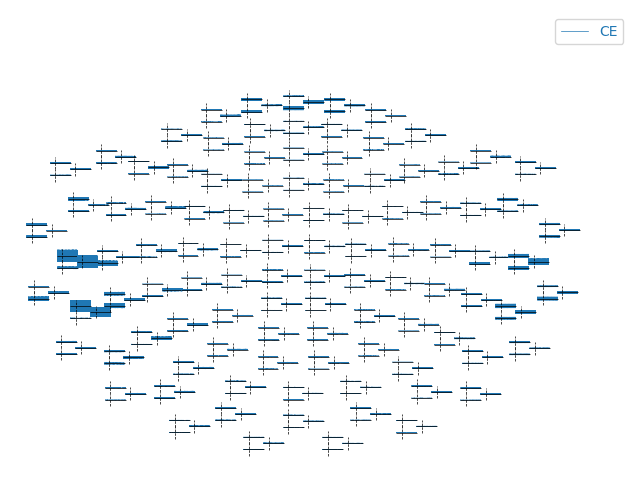

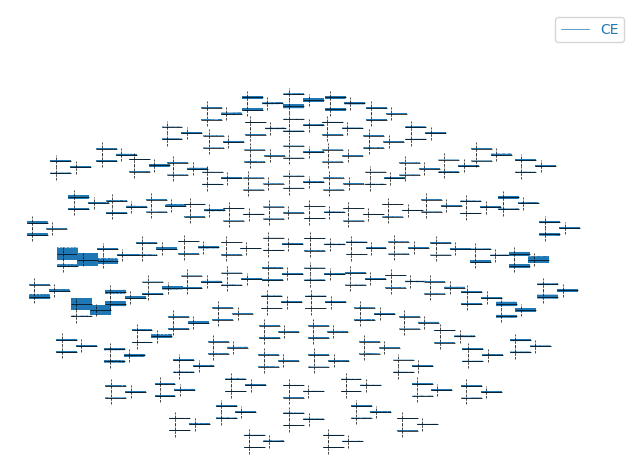

In [ ]:
mne.viz.plot_evoked_topo(evokeds[3])

Need more than one channel to make topography for grad. Disabling interactivity.
Need more than one channel to make topography for mag. Disabling interactivity.


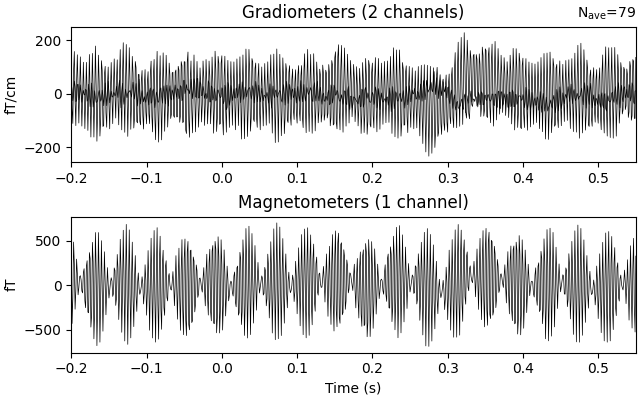

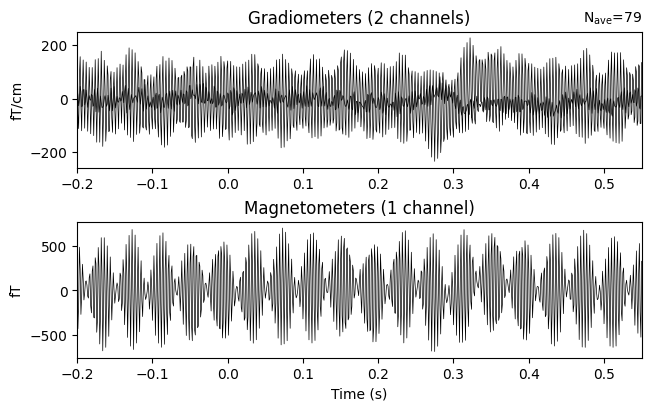

In [ ]:
mne.viz.plot_evoked(evoked_diffs[3], picks=['MEG2043', 'MEG2042', 'MEG2031'])

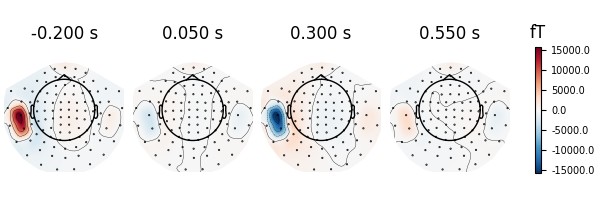

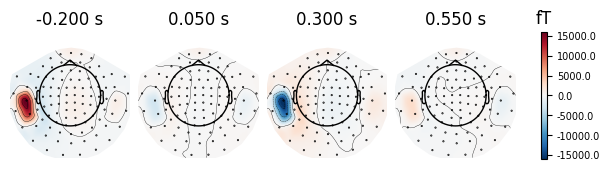

In [ ]:
mne.viz.plot_evoked_topomap(evokeds[3])

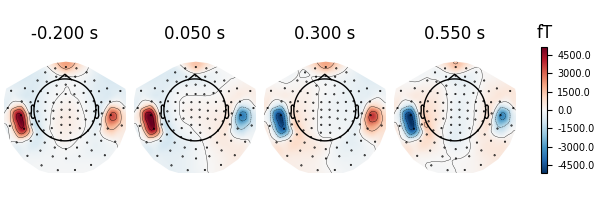

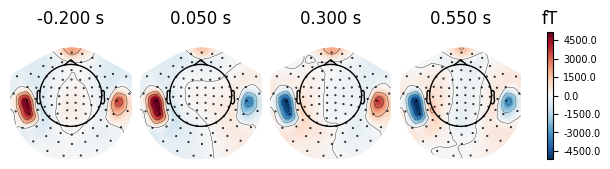

In [ ]:
mne.viz.plot_evoked_topomap(evokeds[0])

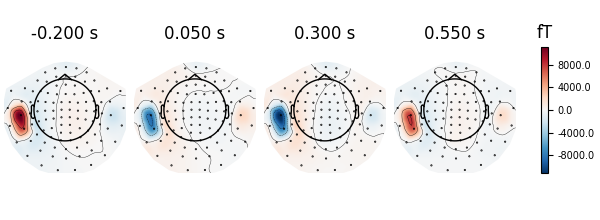

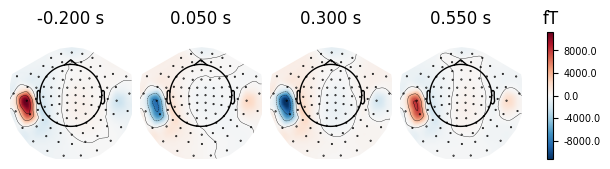

In [ ]:
mne.viz.plot_evoked_topomap(evoked_diffs[3])

## PLOT THE EVOKEDS AND THEIR DIFFERENCE WAVES
Find out where the differences are the greatest - what does this indicate
Use `mne.viz.plot_evoked`, `mne.viz.plot_evoked_topo`, `mne.viz.plot_evoked_topomap`, `mne.viz.plot_evoked_joint`, `mne.viz.plot_evoked_image` to get a feel for the data.


## FORWARD MODEL

$\boldsymbol L (\boldsymbol r)$ is our forward model that for each source location $\boldsymbol r$, expresses how that source is linked to the sensors. The SI-unit is $\frac {T} {Am}$.  
The SI-unit for the magnetic field at each time point, $t$, $\boldsymbol b (t)$ is $T$.  
The SI-unit for the current density $\boldsymbol s(\boldsymbol r, t)$  at each location $\boldsymbol r$ and time point $t$ is $Am$.  
The forward model states for each source at whatever $\boldsymbol r$ how its activation in $Am$ is linked to the magnetic field at each sensor, e.g. $b_1(t)$.  
$\boldsymbol n(t)$ is the Gaussian noise at each time point

$\boldsymbol b(t) = \left[
\begin{array}{c} 
b_1(t) \\
b_2(t) \\
\vdots \\
b_M(t)
\end{array}
\right]$  
$\boldsymbol{b}(t) = \boldsymbol{L}(\boldsymbol{r}) \boldsymbol s(\boldsymbol r, t) + \boldsymbol n(t)$

### NEW CODE

Two of the ingredients have been created for you. The `bem` and the `src`


### OLD CODE

The nice people from MNE-Python have already made a forward model for us

In [ ]:
evoked=epochs[event_id['ACE']].average()

In [ ]:
evoked.info

<Info | 24 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: MEG0111, MEG0112, MEG0113, MEG0121, MEG0122, MEG0123, MEG0131, ...
 chs: 102 Magnetometers, 204 Gradiometers
 custom_ref_applied: False
 description: TRIUX system at Aarhus-3103
 dev_head_t: MEG device -> head transform
 dig: 411 items (3 Cardinal, 4 HPI, 404 Extra)
 events: 1 item (list)
 experimenter: Lau Andersen (lau)
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date: 2025-09-23 08:31:05 UTC
 meas_id: 4 items (dict)
 nchan: 306
 proj_id: 64
 proj_name: cogsci_teaching
 projs: planar-Raw-0.000-120.000-PCA-01: on, planar- ...
 sfreq: 1000.0 Hz
 subject_info: <subject_info | id: 3489, last_name: 0169, first_name: 113, birthday: 1997-08-18, sex: 2, hand: 2>
>

In [ ]:
subjects_dir

'/work/freesurfer'

In [ ]:
## GET FORWARD MODEL

### NEW CODE

info = evoked.info
trans = join(MEG_path, 'workshop_2025-trans.fif') ## this, we don't have yet - we will create this together
src = join(subjects_dir, "0169", 'bem', "0169" + '-oct-6-src.fif')
bem = join(subjects_dir, "0169", 'bem', "0169" + '-5120-bem-sol.fif')

fwd = mne.make_forward_solution(
                            info, trans,
                            src, bem)


### OLD CODE

#fwd = mne.read_forward_solution('sample_audvis-meg-eeg-oct-6-fwd.fif')

Source space          : /work/freesurfer/0169/bem/0169-oct-6-src.fif
MRI -> head transform : /work/MEG_data/workshop_data/0169/20250923_000000/workshop_2025-trans.fif
Measurement data      : instance of Info
Conductor model   : /work/freesurfer/0169/bem/0169-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /work/freesurfer/0169/bem/0169-oct-6-src.fif...
Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999953 -0.002030 -0.009481      -0.95 mm
    0.005052 0.943696 0.330775      13.10 mm
    0.008275 -0.330807 0.943662      27.80 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.994255 0.105501 0.018056       4.03 mm
    -0.105149 0.994267 -0.019438       1.63 mm
    -0.020003 0.017428 0.999648      62.97 mm
    0.000000 0.000000 0.000000       1.0

##  THE MINIMUM NORM ESTIMATE

$$
\huge \hat{\boldsymbol \nu}_{vox}(t) = \boldsymbol L_V^T(\boldsymbol G + \epsilon \boldsymbol I)^{-1} \boldsymbol b(t)    
$$
with
$$
\huge \boldsymbol G = \int_\Omega \boldsymbol L (\boldsymbol r) \boldsymbol L^T (\boldsymbol r) d^3r
$$
and with
$$ 
\huge
\boldsymbol{\hat{\nu}}_{vox}(t) = \left[
\begin{array}{c} 
\boldsymbol{\hat s} (\boldsymbol r_1, t) \\
\boldsymbol{\hat s} (\boldsymbol r_2, t) \\
\vdots \\
\boldsymbol{\hat s} (\boldsymbol r_N, t)
\end{array}
\right]  
$$

## CREATE SOURCE TIME COURSES FOR EACH CONDITION

### NEW CODE

Create `stc` (`stc = mne.minimum_norm.apply_inverse`) from `evokeds` , separate ones for each event and maybe also one collapsed across events
- For the noise covariance plots, which of the two kinds of sensors show the highest covariance between sensors? And does that make sense?


### OLD CODE

Create `stc` (`stc = mne.minimum_norm.apply_inverse`) from `evokeds` , separate ones for each event ((LV and RV))
- Do you think you would see more frontal activity in `stc` compared to `stc_eog_cleaned`? And why is that?
- For the noise covariance plots, which of three kinds of sensors show the highest correlations between sensors?

    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 80400
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.4e-10 (2.2e-16 eps * 102 dim * 6.3e+03  max singular value)
    Estimated rank (mag): 96
    MAG: rank 96 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.2e-08 (2.2e-16 eps * 204 dim * 2.5e+05  max singular value)
    Estimated rank (grad): 201
    GRAD: rank 201 computed from 204 data channels with 0 projectors


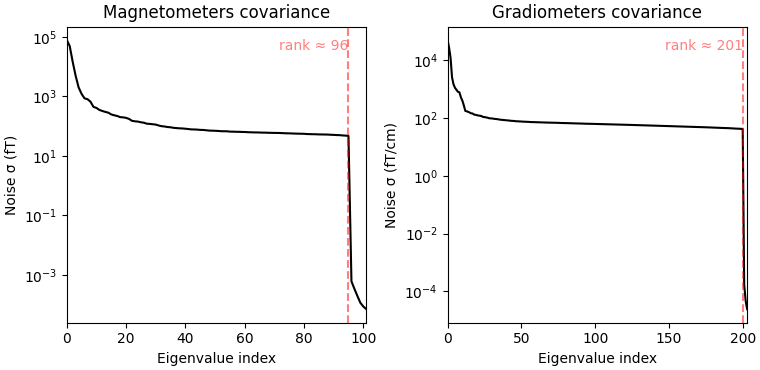

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

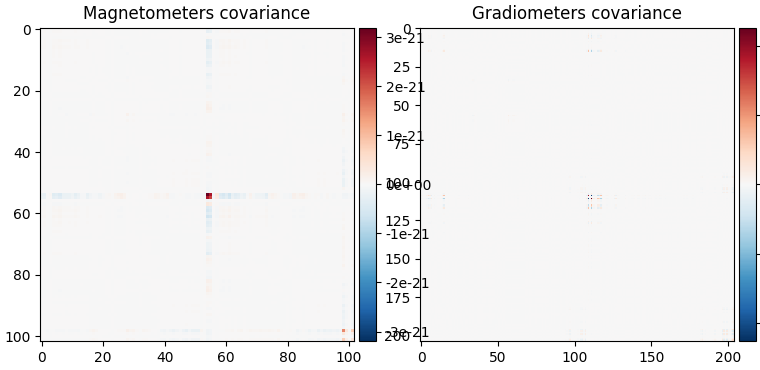

In [ ]:
noise_cov = mne.compute_covariance(epochs, tmin=None, tmax=0)
noise_cov.plot(raw.info)

In [ ]:
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd,
                                                          noise_cov)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7618/8196 = 10.000578
    scale = 4.63926e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 1.8e-08 (2.2e-16 eps * 306 dim * 2.6e+05  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)


/tmp/ipykernel_1099/2649456889.py:1: RuntimeWarning: The largest eigenvalue of the 306-channel meg covariance (rank=297) is over 10 orders of magnitude larger than the smallest (2.54e-17 > 1e10 * 2.16e-27), the resulting whitener will likely be unstable
  inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd,


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


/tmp/ipykernel_1099/2649456889.py:1: RuntimeWarning: The largest eigenvalue of the 306-channel meg covariance (rank=297) is over 10 orders of magnitude larger than the smallest (2.54e-17 > 1e10 * 2.16e-27), the resulting whitener will likely be unstable
  inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd,


    largest singular value = 5.43063
    scaling factor to adjust the trace = 5.62003e+18 (nchan = 306 nzero = 9)


In [ ]:
stc = mne.minimum_norm.apply_inverse(inverse_operator=inverse_operator, evoked=evokeds[3], method='dSPM')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 79
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "CE"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  73.6% variance
    Combining the current components...
    dSPM...
[done]


In [ ]:
stc

<SourceEstimate | 8196 vertices, subject : 0169, tmin : -200.0 (ms), tmax : 550.0 (ms), tstep : 1.0 (ms), data shape : (8196, 751), ~47.0 MiB>

In [ ]:
#import pyvistaqt

In [ ]:
#brain = stc.plot(
#    hemi="rh",
#    views="lat",
#    subjects_dir=subjects_dir,
#    size=(800, 600),
#    background="w",
#)

In [ ]:

### NEW CODE

##  WHITEN the data, i.e. normalizing magnetometers, gradiometers
## and electrode readings to make them comparable
#noise_cov = mne.compute_covariance(epochs, tmin=None, tmax=0)
#noise_cov.plot(raw.info)

#inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd,
#                                                          noise_cov)

# estimating the source pattern for each time point Vvox(t)

#stc = mne.minimum_norm.apply_inverse(evoked=??, method='dSPM') # dSPM makes a depth correction
#Dale AM, Liu AK, Fischl BR, et al (2000) Dynamic Statistical Parametric Mapping: Combining fMRI and MEG for High-Resolution Imaging of Cortical Activity. Neuron 26:55–67. https://doi.org/10.1016/S0896-6273(00)81138-1


### OLD CODE

##  WHITEN the data, i.e. normalizing magnetometers, gradiometers
## and electrode readings to make them comparable
#noise_cov = mne.compute_covariance(epochs, tmin=None, tmax=0)
#noise_cov.plot(raw.info)

#inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd,
#                                                          noise_cov)

# estimating the source pattern for each time point Vvox(t)
# use the MNE method and not the default dSPM
#stc = mne.minimum_norm.apply_inverse(method='MNE')

## EXTRACT RELEVANT LABELS FROM THE CEREBRAL CORTEX

go to your subject label path: and read some relevant labels using `mne.read_label` from there:
 - old path `MNE-sample-data/subjects/sample/label`, 
 - new_path `/work/freesurfer/?subject?/label


That could be:
 - `lh.V1.label`
 - `lh.V2.label`
 - `rh.V1.label`
 - `rh.V2.label`

You can read in even more labels by running `labels = mne.read_labels_from_annot('?subject?, subjects_dir=subjects_dir)`

Plot some (visual) labels that should show a response, using `plt.plot` from `matplotlib`. Here's some code that could get you started:

```
lh_V1_label = mne.read_label(<path_to_lh_V1_label>)
stc_lh_V1_label = stc.in_label(lh_V1_label)
plt.figure()
plt.plot(stc_lh_V1_label.times, stc_lh_V1_label.data.T)
plt.xlabel('Time (s)')
plt.ylabel('Current density (Am)')
plt.title(lh_V1_label.name)
plt.show()

```

Also plot some labels that should not show a response (maybe some language related labels)
Discuss with each other what the lines each represent.

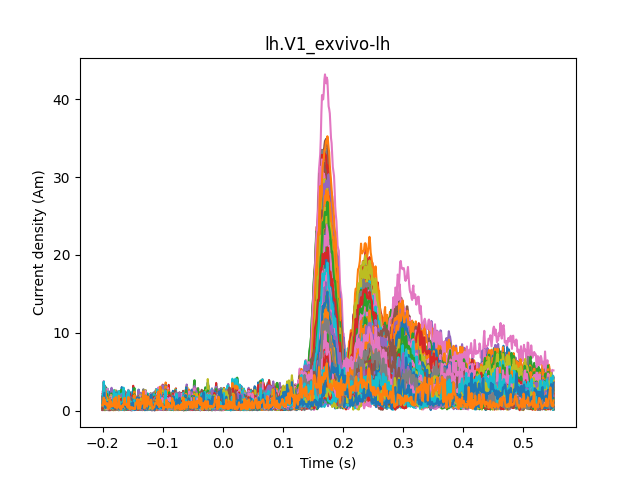

In [ ]:
lh_V1_label = mne.read_label("/work/freesurfer/0169/label/lh.V1_exvivo.label")
stc_lh_V1_label = stc.in_label(lh_V1_label)
plt.figure()
plt.plot(stc_lh_V1_label.times, stc_lh_V1_label.data.T)
plt.xlabel('Time (s)')
plt.ylabel('Current density (Am)')
plt.title(lh_V1_label.name)
plt.show()

In [ ]:
subjects_dir
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
"""
LAUS KODE
## GETTING SOURCE TIME COURSES FROM EPOCHS
stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inverse_operator, lambda2=1, method='dSPM')

## READING LABELS FROM ANNOTATION
labels = mne.read_labels_from_annot('0169', subjects_dir=subjects_dir)

## EXTRACT LABELS FROM MULTIPLE STCS
def extract_label(label, stcs):
    label_stcs = list()
    for stc in stcs:
        label_stcs.append(stc.in_label(label))
                        
    return label_stcs


#%% CREATE X AND Y FOR LOGISTIC REGRESSIOM

#import numpy as np
label_stcs = [extract_label(label, stcs) for label in labels]


y = epochs.events[:, 2] # the codes for the visual events

n_events = len(y) ## how many repetitions
n_samples = label_stcs[0][0].data.shape[1] # how many time points
n_label_vertices = label_stcs[0][0].data.shape[0]  # how many source positions

X = np.zeros(shape=(n_events, n_label_vertices, n_samples))

## assign data to X
for event_index in range(n_events):
    X[event_index, :, :] = label_stcs[0][event_index].data
    
        
    #%% DO LOGISTIC REGRESSION PER TIME SAMPLE

    #from sklearn.linear_model import LogisticRegression
    #from sklearn.model_selection import cross_val_score, StratifiedKFold
    #from sklearn.preprocessing import StandardScaler

    scores_list_samples = [None] * n_samples

    sc = StandardScaler()

    for sample_index in range(n_samples):
        print(sample_index)
        this_X = X[:, :, sample_index]
        this_X_std = sc.fit_transform(this_X) ## standardise the data
        logr = LogisticRegression(C=1e-3)
        scores_list_samples[sample_index] = np.mean(cross_val_score(logr,
                                                                    this_X_std,
                                                                    y,
                                                                    cv=StratifiedKFold(),
                                                                    n_jobs=-1))


## PLOTTING THE CLASSIFICATION ACCURACY

plt.figure()
plt.plot(stc.times, scores_list_samples)
plt.title('Classification of LV vs RV')
plt.xlabel('Time (s)')
plt.ylabel('Proportion correctly classif')
plt.show()

"""
    


"\nLAUS KODE\n## GETTING SOURCE TIME COURSES FROM EPOCHS\nstcs = mne.minimum_norm.apply_inverse_epochs(epochs, inverse_operator, lambda2=1, method='dSPM')\n\n## READING LABELS FROM ANNOTATION\nlabels = mne.read_labels_from_annot('0169', subjects_dir=subjects_dir)\n\n## EXTRACT LABELS FROM MULTIPLE STCS\ndef extract_label(label, stcs):\n    label_stcs = list()\n    for stc in stcs:\n        label_stcs.append(stc.in_label(label))\n\n    return label_stcs\n\n\n#%% CREATE X AND Y FOR LOGISTIC REGRESSIOM\n\n#import numpy as np\nlabel_stcs = [extract_label(label, stcs) for label in labels]\n\n\ny = epochs.events[:, 2] # the codes for the visual events\n\nn_events = len(y) ## how many repetitions\nn_samples = label_stcs[0][0].data.shape[1] # how many time points\nn_label_vertices = label_stcs[0][0].data.shape[0]  # how many source positions\n\nX = np.zeros(shape=(n_events, n_label_vertices, n_samples))\n\n## assign data to X\nfor event_index in range(n_events):\n    X[event_index, :, :] = lab

In [ ]:
epochs.events

array([[2089664,       0,      21],
       [2094768,       0,      21],
       [2100245,       0,      21],
       ...,
       [3583338,       0,      22],
       [3587116,       0,      21],
       [3591443,       0,      21]], shape=(400, 3))

In [ ]:
epochs_decoding = epochs_eog_cleaned

In [ ]:
epochs_eog_cleaned

<Epochs | 336 events (all good), -0.2 – 0.55 s (baseline -0.2 – 0 s), ~607.8 MiB, data loaded,
 'NE': 58
 'WG': 127
 'ACE': 94
 'CE': 57>

In [ ]:
epochs

<Epochs | 400 events (all good), -0.2 – 0.55 s (baseline -0.2 – 0 s), ~722.6 MiB, data loaded,
 'NE': 62
 'WG': 139
 'ACE': 120
 'CE': 79>

In [ ]:
epochs_decoding

<Epochs | 336 events (all good), -0.2 – 0.55 s (baseline -0.2 – 0 s), ~607.8 MiB, data loaded,
 'NE': 58
 'WG': 127
 'ACE': 94
 'CE': 57>

In [ ]:
subjects_dir

'/work/freesurfer'

In [ ]:
epochs_decoding = epochs_eog

NameError: name 'epochs_eog' is not defined

Fitting ICA to data using 306 channels (please be patient, this may take a while)


/tmp/ipykernel_8513/710255222.py:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs_decoding)


    Applying projection operator with 9 vectors (pre-whitener computation)
    Applying projection operator with 9 vectors (pre-whitener application)
Selecting by explained variance: 3 components
    Applying projection operator with 9 vectors (pre-whitener application)
Fitting ICA took 10.1s.


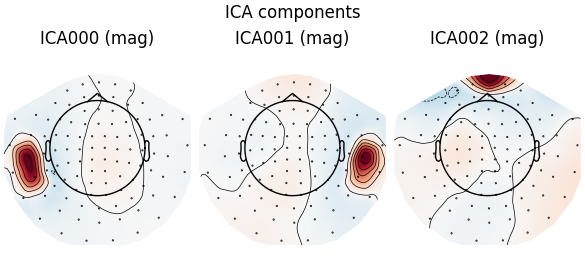

    Applying projection operator with 9 vectors (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated


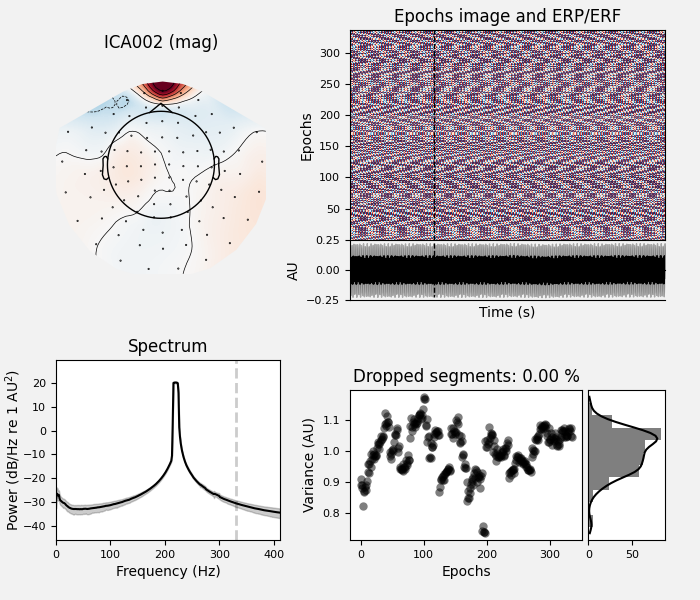

    Applying projection operator with 9 vectors (pre-whitener application)
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated


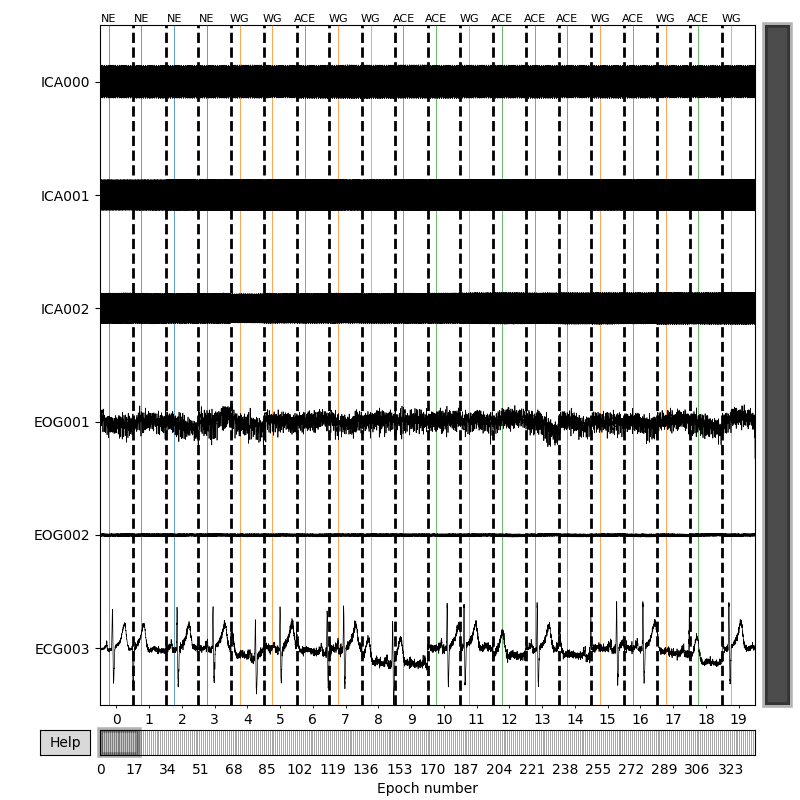

Using EOG channels: EOG001, EOG002
    Applying projection operator with 9 vectors (pre-whitener application)
    Applying projection operator with 9 vectors (pre-whitener application)
Applying ICA to Epochs instance


/tmp/ipykernel_8513/710255222.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_clean = ica.apply(epochs_decoding.copy())


    Applying projection operator with 9 vectors (pre-whitener application)
    Transforming to ICA space (3 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


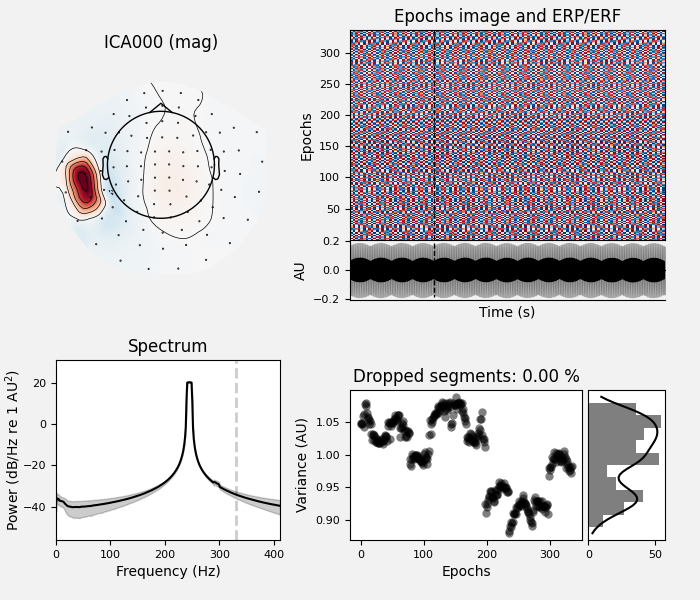

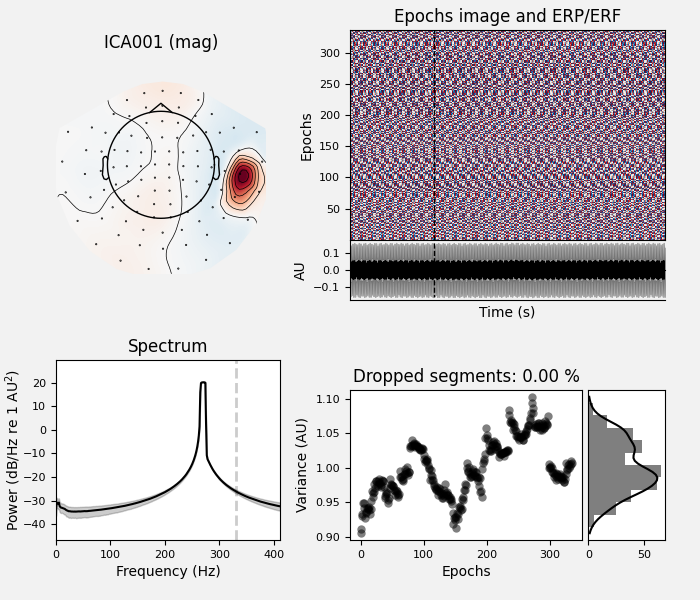

In [ ]:
ica = mne.preprocessing.ICA(n_components=0.99, method='fastica', random_state=97)
ica.fit(epochs_decoding)

# 3️⃣ Find typical artifact components
ica.plot_components()        # visually inspect components
ica.plot_properties(epochs_decoding, picks=[0, 1, 2])  # inspect top suspects
ica.plot_sources(epochs_decoding)     # blink/muscle/ECG patterns visible

# 4️⃣ Automatically detect EOG/ECG components (optional)
eog_inds, scores = ica.find_bads_eog(epochs_decoding)
ica.exclude = eog_inds

# 5️⃣ Apply ICA clean projection
epochs_clean = ica.apply(epochs_decoding.copy())

# 6️⃣ Proceed to decoding
X = epochs_clean.get_data(picks='meg')  # or EEG
y = epochs_clean.events[:, 2]

In [ ]:
##FILTERING as to only use events NE and CE

# And the event codes you want to keep are 21 and 24

filter_events = [21, 24]

# Create a boolean mask for the epochs you want

mask = np.isin(epochs_clean.events[:, 2], filter_events)

  

# Apply the mask to get filtered epochs

epochs_filtered = epochs_clean[mask]

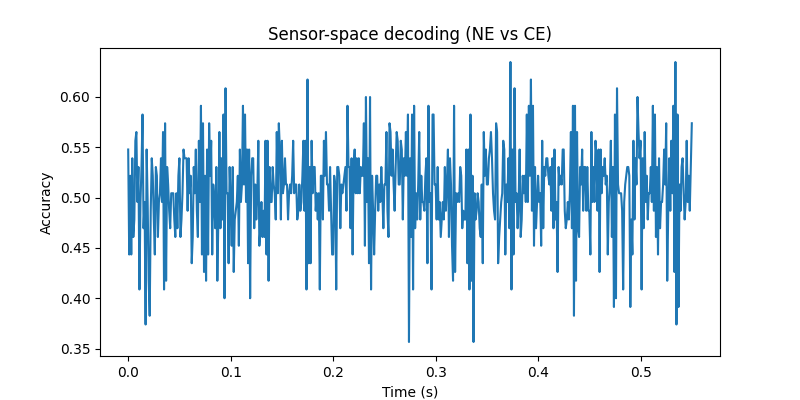

In [ ]:
## deocoding in sensor space
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# -------------------------------
# PARAMETERS
# -------------------------------
n_jobs_outer = 64
decimation = 1
cv_folds = 5
C_reg = 1e-3
n_skip = 200  # discard first 200 samples

# -------------------------------
# USE SENSOR-LEVEL EPOCHS DIRECTLY
# -------------------------------
# (assume epochs_filtered contains only your relevant events)
X = epochs_filtered.get_data()  # shape = (n_events, n_channels, n_times)
y = epochs_filtered.events[:, 2]

# Optional: restrict to MEG or EEG channels only
# picks = mne.pick_types(epochs_filtered.info, meg=True, eeg=False)
# X = epochs_filtered.get_data(picks=picks)

# Drop pre-stim samples
X = X[:, :, n_skip:][:, :, ::decimation]
times = epochs_filtered.times[n_skip:][::decimation]
n_events, n_channels, n_samples = X.shape

# -------------------------------
# CLASSIFIER SETUP
# -------------------------------
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True)
logr = LogisticRegression(C=C_reg, solver='liblinear', max_iter=1000)
sc = StandardScaler()

# -------------------------------
# FUNCTION FOR SINGLE TIME SAMPLE
# -------------------------------
def decode_time_sample(sample_idx):
    this_X = X[:, :, sample_idx]
    this_X_std = sc.fit_transform(this_X)
    score = np.mean(cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=1))
    return score

# -------------------------------
# PARALLEL DECODING
# -------------------------------
scores_list_samples = Parallel(n_jobs=n_jobs_outer)(
    delayed(decode_time_sample)(t) for t in range(n_samples)
)

# -------------------------------
# PLOT RESULTS
# -------------------------------
plt.figure(figsize=(8,4))
plt.plot(times, scores_list_samples)
plt.title('Sensor-space decoding (NE vs CE)')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.show()


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 115
combining the current components...
Processing epoch : 2 / 115
combining the current components...
Processing epoch : 3 / 115
combining the current components...
Processing epoch : 4 / 115
combining the current components...
Processing epoch : 5 / 115
combining the current components...
Processing epoch : 6 / 115
combining the current components...
Processing epoch : 7 / 115
combining the current components...
Processing epoch : 8 / 115
combining the current components...
Processing epoch : 9 / 115
combining the curr

combining the current components...
Processing epoch : 33 / 115
combining the current components...
Processing epoch : 34 / 115
combining the current components...
Processing epoch : 35 / 115
combining the current components...
Processing epoch : 36 / 115
combining the current components...
Processing epoch : 37 / 115
combining the current components...
Processing epoch : 38 / 115
combining the current components...
Processing epoch : 39 / 115
combining the current components...
Processing epoch : 40 / 115
combining the current components...
Processing epoch : 41 / 115
combining the current components...
Processing epoch : 42 / 115
combining the current components...
Processing epoch : 43 / 115
combining the current components...
Processing epoch : 44 / 115
combining the current components...
Processing epoch : 45 / 115
combining the current components...
Processing epoch : 46 / 115
combining the current components...
Processing epoch : 47 / 115
combining the current components...
Proc

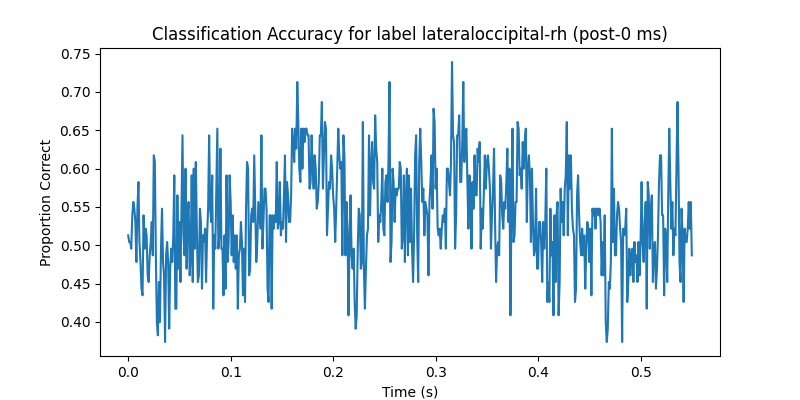

In [ ]:
# DECODING IN SOURCE SPACE (works)

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import mne

# -------------------------------

# PARAMETERS

# -------------------------------

n_jobs_outer = 64   # number of cores for time point parallelization

decimation = 1      # take every N-th sample (1 = no decimation)

cv_folds = 5

C_reg = 1e-3

label_index = 23    # label to decode  - this is lateral occipital

n_skip = 200        # number of initial samples to discard (pre-0 ms)

  

# -------------------------------

# APPLY INVERSE OPERATOR

# -------------------------------

stcs = mne.minimum_norm.apply_inverse_epochs(

    epochs_filtered, inverse_operator, lambda2=1, method='dSPM'

)

  

# -------------------------------

# READ LABELS

# -------------------------------

labels = mne.read_labels_from_annot('0169', subjects_dir=subjects_dir)

  

# -------------------------------

# EXTRACT LABELS

# -------------------------------

def extract_label(label, stcs):

    return [stc.in_label(label) for stc in stcs]

  

label_stcs = [extract_label(label, stcs) for label in labels]

  

# -------------------------------

# SELECT LABEL AND BUILD X

# -------------------------------

stcs_for_label = label_stcs[label_index]

label_name = labels[label_index].name

  

n_events = len(stcs_for_label)

n_label_vertices = stcs_for_label[0].data.shape[0]

n_samples = stcs_for_label[0].data.shape[1]

  

# Build X: shape = (n_events, n_vertices, n_samples)

X = np.zeros((n_events, n_label_vertices, n_samples))

for i in range(n_events):

    X[i, :, :] = stcs_for_label[i].data

  

# -------------------------------

# DISCARD FIRST 200 SAMPLES

# -------------------------------

X = X[:, :, n_skip:]

times = stcs_for_label[0].times[n_skip:]

n_samples = X.shape[2]

  

# -------------------------------

# LABELS

# -------------------------------

y = epochs_filtered.events[:, 2]

  

# -------------------------------

# CROSS-VALIDATION SETUP

# -------------------------------

cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

logr = LogisticRegression(C=C_reg, solver='liblinear', max_iter=1000)

sc = StandardScaler()

  

# -------------------------------

# FUNCTION TO DECODE ONE TIME SAMPLE

# -------------------------------

def decode_time_sample(sample_idx):

    this_X = X[:, :, sample_idx]

    this_X_std = sc.fit_transform(this_X)

    score = np.mean(cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=1))
    return score

  

# -------------------------------

# PARALLEL DECODING ACROSS TIME POINTS

# -------------------------------

scores_list_samples = Parallel(n_jobs=n_jobs_outer)(
    delayed(decode_time_sample)(t) for t in range(n_samples)

)

  

# -------------------------------

# PLOT RESULTS

# -------------------------------

plt.figure(figsize=(8,4))

plt.plot(times, scores_list_samples)

plt.title(f'Classification Accuracy for label {label_name} (post-0 ms)')

plt.xlabel('Time (s)')

plt.ylabel('Proportion Correct')

plt.show()

##  MACHINE LEARNING LOGISTIC REGRESSION 

Finally, we are going to do some machine learning on this data, trying to predict whether the checkerboard was shown in the left visual field or the right visual field. For this we need to do source reconstruction of the epochs instead.


Below is some code to get you started - **this is the old code; please adapt to your analysis**

```

## GETTING SOURCE TIME COURSES FROM EPOCHS

stcs = mne.minimum_norm.apply_inverse_epochs(epochs, lambda=1, method='MNE')

## READING LABELS FROM ANNOTATION
labels = mne.read_labels_from_annot('sample', subjects_dir=subjects_dir)

## EXTRACT LABELS FROM MULTIPLE STCS
def extract_label(label, stcs):
    label_stcs = list()
    for stc in stcs:
        label_stcs.append(stc.in_label(label))
        
    return label_stcs


#%% CREATE X AND Y FOR LOGISTIC REGRESSIOM

import numpy as np

y = epochs.events[:, 2] # the codes for the visual events

n_events = len(y) ## how many repetitions
n_samples = label_stcs[0].data.shape[1] # how many time points
n_label_vertices = label_stcs[0].data.shape[0]  # how many source positions

X = np.zeros(shape=(n_events, n_label_vertices, n_samples))

## assign data to X
for event_index in range(n_events):
    X[event_index, :, :] = label_stcs[event_index].data
    
    
#%% DO LOGISTIC REGRESSION PER TIME SAMPLE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

scores_list_samples = [None] * n_samples

sc = StandardScaler()

for sample_index in range(n_samples):
    print(sample_index)
    this_X = X[:, :, sample_index]
    this_X_std = sc.fit_transform(this_X) ## standardise the data
    logr = LogisticRegression(C=1e-3)
    scores_list_samples[sample_index] = np.mean(cross_val_score(logr,
                                                                this_X_std,
                                                                y,
                                                        cv=StratifiedKFold()))


## PLOTTING THE CLASSIFICATION ACCURACY

plt.figure()
plt.plot(stc.times, scores_list_samples)
plt.show()
plt.title('Classification of LV vs RV')
plt.xlabel('Time (s)')
plt.ylabel('Proportion correctly classif')



    
```

## THINKING AHEAD - QUESTIONS YOU MIGHT WANT TO PONDER ON

 - How to conduct a group analysis? (You could get inspired below)
    - Andersen LM (2018) Group Analysis in MNE-Python of Evoked Responses from a Tactile Stimulation Paradigm: A Pipeline for Reproducibility at Every Step of Processing, Going from Individual Sensor Space Representations to an across-Group Source Space Representation. Frontiers in Neuroscience 12:
    - Andersen LM (2023) Software and Resources for Experiments and Data Analysis. In: Grimaldi M, Brattico E, Shtyrov Y (eds) Language Electrified: Principles, Methods, and Future Perspectives of Investigation. Springer US, New York, NY, pp 65–122
 - What to do about physiological signals?
   - Independent Component Analysis?
   - Reject trials with physiological signals?
   - Leave them in and use beamformer instead of MNE?
 - In the multivariate analyses, what to do about the differences in contrasts per trial?
   - Regress contrast differences out?
      - Barnett B, Andersen LM, Fleming SM, Dijkstra N (2024) Identifying content-invariant neural signatures of perceptual vividness. PNAS Nexus 3:pgae061. https://doi.org/10.1093/pnasnexus/pgae061
 - Do a behavioural analysis
   - Do we see differences in response times and accuracy between different levels of PAS?
   - Create some code that cleans up the column mess in the log file (don't change the log itself)

